In [1]:
import os
import neptune
import torch
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastai.vision.all import *
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import matplotlib.cm as cm
from fastai.learner import load_learner

In [2]:
# Testdatensatz laden
DATASET_DIR = "balanced_dataset_split/balanced_dataset_split"
JSON_PATH = "train_test_split_new.json"

with open(JSON_PATH, "r") as f:
    split_data = json.load(f)

df_test = pd.DataFrame(split_data["test"])
df_test["image_path"] = df_test["file_path"].apply(lambda x: os.path.join(DATASET_DIR, x))

# Vokabular für die Labels erstellen
vocab = df_test["label"].unique().tolist()

# DataBlock für Testdaten
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock(vocab=vocab)),
    get_x=ColReader('image_path'),
    get_y=ColReader('label'),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
)
dls = dblock.dataloaders(df_test, bs=8, num_workers=8)
test_dl = dls.test_dl(df_test, with_labels=True)

# Device erkennen (GPU oder CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


📥 Lade Modell: AlexNet...
📊 Ergebnisse für AlexNet: Accuracy=0.2079, Precision=0.3652, Recall=0.1305, F1-Score=0.1139
📥 Lade Modell: ResNet50...
📊 Ergebnisse für ResNet50: Accuracy=0.7192, Precision=0.7779, Recall=0.6171, F1-Score=0.6464
📥 Lade Modell: GoogLeNet...
📊 Ergebnisse für GoogLeNet: Accuracy=0.6544, Precision=0.7292, Recall=0.5502, F1-Score=0.5870
📥 Lade Modell: VGG16...
📊 Ergebnisse für VGG16: Accuracy=0.6188, Precision=0.7421, Recall=0.5279, F1-Score=0.5565
📥 Lade Modell: VGG19...
📊 Ergebnisse für VGG19: Accuracy=0.6384, Precision=0.6719, Recall=0.5136, F1-Score=0.5419
📥 Lade Modell: ViT...
📊 Ergebnisse für ViT: Accuracy=0.8709, Precision=0.8462, Recall=0.8298, F1-Score=0.8304


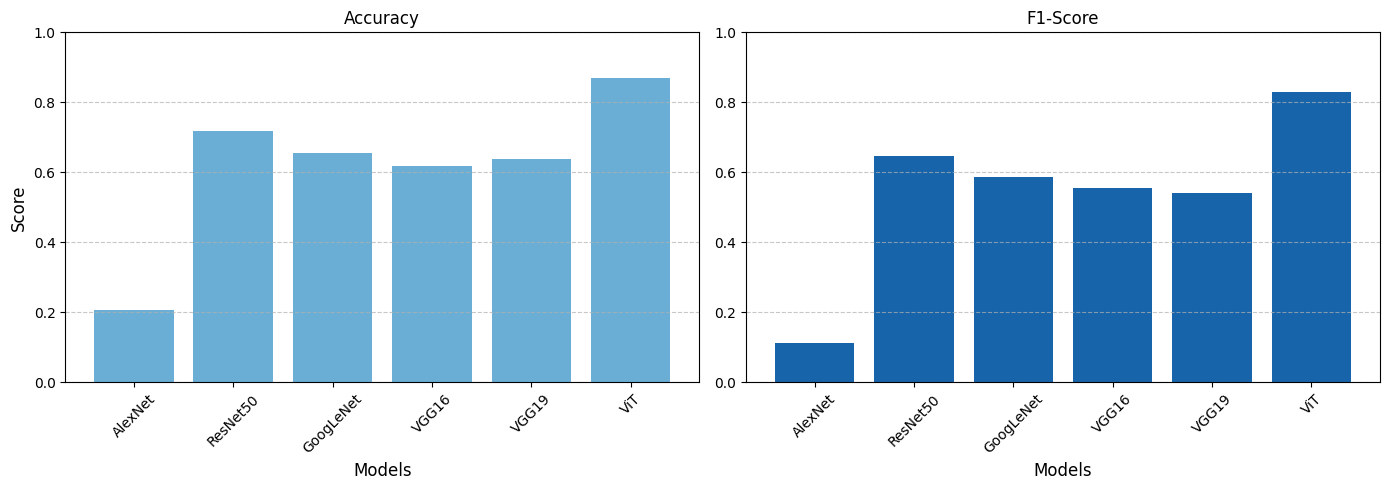

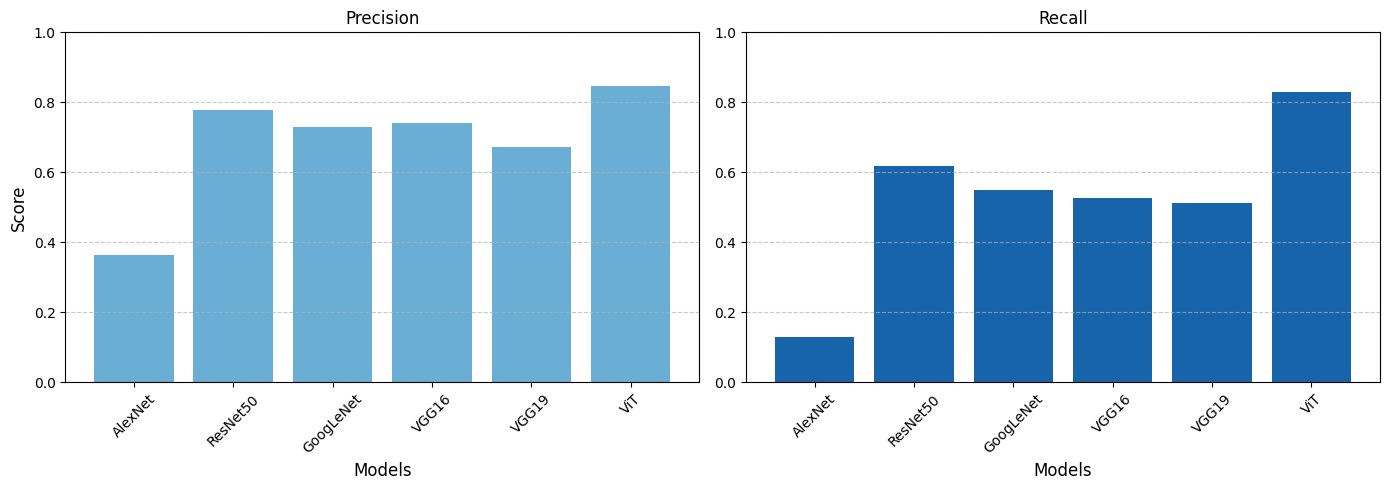

In [ ]:
# === Modelle aus "trained_models" laden ===
MODEL_DIR = "trained models/trained models"

model_files = [
    "basemodel_outputs/basemodel_alexnet_bs8.pkl",
    "basemodel_outputs/basemodel_resnet50_bs8.pkl" ,
    "basemodel_outputs/basemodel_googlenet_bs8.pkl",
    "basemodel_outputs/basemodel_vgg16_bn_bs8.pkl",
    "basemodel_outputs/basemodel_vgg19_bn_bs8.pkl",
    "basemodel_outputs/basemodel_ViT_bs8.pkl"
]

# === Mapping von Dateinamen zu schöneren Modelnamen ===
model_name_mapping = {
    "basemodel_alexnet_bs8": "AlexNet",
    "basemodel_resnet50_bs8": "ResNet50",
    "basemodel_googlenet_bs8": "GoogLeNet",
    "basemodel_vgg16_bn_bs8": "VGG16",
    "basemodel_vgg19_bn_bs8": "VGG19",
    "basemodel_ViT_bs8": "ViT"
}

# === Ergebnisse speichern ===
results = []

# === Alle Modelle durchlaufen ===
for model_file in model_files:
    #model_name = model_file.replace(".pkl", "").split("/")[-1]
    model_key = model_file.replace(".pkl", "").split("/")[-1]
    model_name = model_name_mapping.get(model_key, model_key)
    model_path = model_file

    print(f"📥 Lade Modell: {model_name}...")

    # === Modell in FastAI laden ===
    learn = load_learner(model_path)
    learn.model.to(device)
    learn.model.eval()

    # === Vorhersagen sammeln ===
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in test_dl:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            outputs = learn.model(images)
            preds = torch.argmax(outputs, dim=1)

            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    # === Metriken berechnen ===
    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='macro', zero_division=0)

    # === Confusion Matrix berechnen & speichern ===
    #cm = confusion_matrix(true_labels, pred_labels)
    #plt.figure(figsize=(10, 10))
    #sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=vocab, yticklabels=vocab)
    #plt.xlabel('Predicted Labels')
    #plt.ylabel('True Labels')
    #plt.title(f'Confusion Matrix - {model_name}')

    #cm_path = f"images/confusion_matrices_{model_name}.png"
    #plt.savefig(cm_path)
    #plt.close()
    #print(f"📁 Confusion Matrix gespeichert: {cm_path}")

    # === Ergebnisse speichern ===
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

    print(f"Ergebnisse für {model_name}: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}")

# === Ergebnisse als DataFrame anzeigen ===
df_metrics = pd.DataFrame(results)
df_metrics.head()

# === Subplots: Accuracy und F1-Score nebeneinander ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Farben aus der "Blues"-Colormap
blues = plt.get_cmap("Blues")

# Farbstufen für 2 Balkendiagramme nebeneinander
color1 = blues(0.5)  
color2 = blues(0.8)

# Accuracy
axes[0].bar(df_metrics["Model"], df_metrics["Accuracy"], color=color1)
axes[0].set_title("Accuracy", fontsize=12)
axes[0].set_ylim(0, 1)
axes[0].set_xlabel("Models", fontsize=12)
axes[0].set_ylabel("Score", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# F1-Score
axes[1].bar(df_metrics["Model"], df_metrics["F1-Score"], color=color2)
axes[1].set_title("F1-Score", fontsize=12)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Models", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("images/accuracy_f1_bs8.png", dpi=300)
plt.show()

# === Subplots: Precision und Recall nebeneinander ===
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Precision
axes[0].bar(df_metrics["Model"], df_metrics["Precision"], color=color1)
axes[0].set_title("Precision", fontsize=12)
axes[0].set_ylim(0, 1)
axes[0].set_xlabel("Models", fontsize=12)
axes[0].set_ylabel("Score", fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

# Recall
axes[1].bar(df_metrics["Model"], df_metrics["Recall"], color=color2)
axes[1].set_title("Recall", fontsize=12)
axes[1].set_ylim(0, 1)
axes[1].set_xlabel("Models", fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("images/precision_recall_bs8.png", dpi=300)
plt.show()

In [15]:
df_metrics.head(7)

,Model,Accuracy,Precision,Recall,F1-Score
0,AlexNet,0.207936,0.365199,0.130501,0.113915
1,ResNet50,0.719237,0.777909,0.617076,0.646359
2,GoogLeNet,0.654445,0.729224,0.550229,0.587032
3,VGG16,0.618785,0.742146,0.527902,0.556468
4,VGG19,0.638373,0.671859,0.513631,0.541851
5,ViT,0.870919,0.846236,0.829765,0.830359


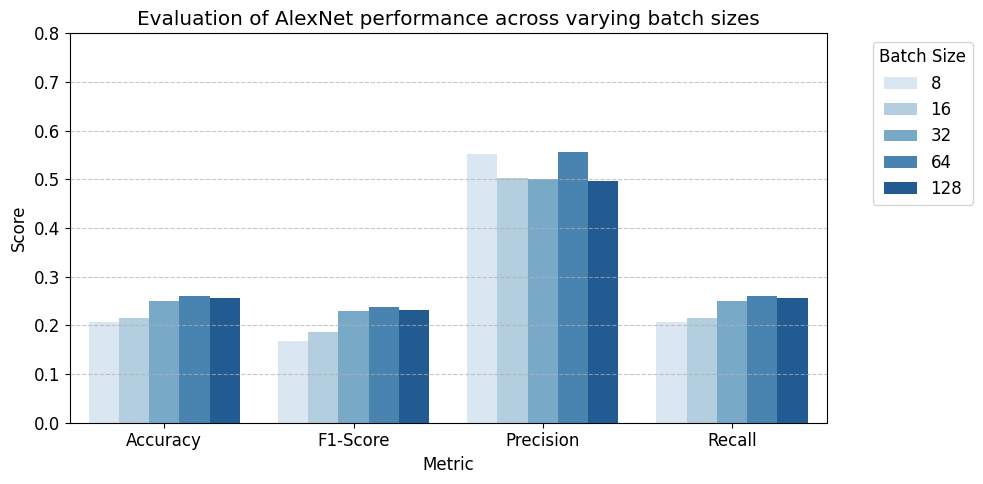

In [ ]:
# Evaluation of AlexNet with different batch sizes

# Schriftgröße global setzen
plt.rcParams.update({'font.size': 12})

# Modelle & Pfade
models_info = {
    "8": "basemodel_outputs/basemodel_alexnet_bs8.pkl",
    "16": "basemodel_outputs/basemodel_alexnet_bs16.pkl",
    "32": "basemodel_outputs/basemodel_alexnet_bs32.pkl",
    "64": "basemodel_outputs/basemodel_alexnet_bs64.pkl",
    "128": "basemodel_outputs/basemodel_alexnet_bs128.pkl"
}

results = []

for model_name, model_path in models_info.items():
    learn = load_learner(model_path)
    
    preds, targs = learn.get_preds(dl=test_dl)
    pred_labels = preds.argmax(dim=1)

    acc = accuracy_score(targs, pred_labels)
    prec = precision_score(targs, pred_labels, average='weighted', zero_division=0)
    rec = recall_score(targs, pred_labels, average='weighted')
    f1 = f1_score(targs, pred_labels, average='weighted')

    results.append({
        "Model": model_name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })

# Colormap laden
blues = plt.get_cmap("Blues")

# DataFrame mit Ergebnissen 
df_results = pd.DataFrame(results)
metrics = ["Accuracy", "F1-Score", "Precision", "Recall"]

# Melt für einfaches Plotten
df_melted = df_results.melt(id_vars="Model", value_vars=metrics, var_name="Metric", value_name="Score")

# Farbpalette aus der Colormap erzeugen
unique_models = df_results["Model"].nunique()
colors = [blues(i / (unique_models + 1)) for i in range(1, unique_models + 1)]

# plot
plt.figure(figsize=(10, 5))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model", palette=colors)

plt.title("Evaluation of AlexNet performance across varying batch sizes")
plt.ylim(0, 0.8)
plt.ylabel("Score")
plt.legend(title="Batch Size", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/alexnet_batchsizes_metrics.png", dpi=300)
plt.show()

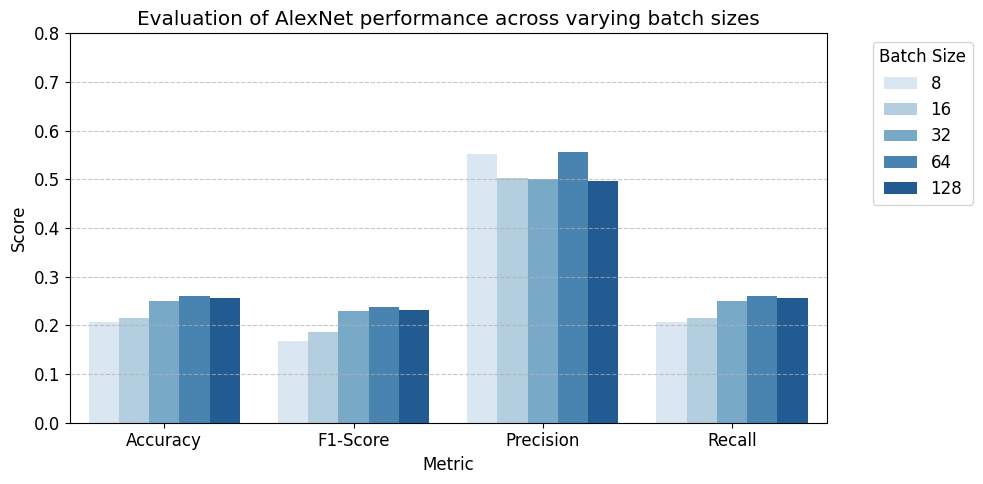

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Model", palette=colors)

plt.title("Evaluation of AlexNet performance across varying batch sizes")
plt.ylim(0, 0.8)
plt.ylabel("Score")
plt.legend(title="Batch Size", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig("images/alexnet_batchsizes_metrics.png", dpi=300)
plt.show()

In [5]:
df_results.head(7)

,Model,Accuracy,Precision,Recall,F1-Score
0,8,0.207936,0.551179,0.207936,0.168084
1,16,0.215470,0.503682,0.215470,0.185924
2,32,0.250628,0.500169,0.250628,0.228863
3,64,0.261175,0.556234,0.261175,0.237632
4,128,0.255650,0.496843,0.255650,0.231154


In [ ]:
# load model from neptune

# Neptune.ai API-Token und Projektname
api_token="insert_your_api_token_here"

run_id = "DLMOD-114"
model_name = "ViT_bs64+augm+iNat"

# Neptune.ai-Projekt initialisieren
project = neptune.init_project(
    project=project_name,
    api_token=api_token,
    mode="read-only"
)

# Neptune Run initialisieren
run = neptune.init_run(
    project=project_name,
    api_token=api_token,
    with_id=run_id,
    mode="read-only"
)
local_model_path = f"basemodel_outputs/basemodel_{model_name}.pkl"

# Modell aus Neptune herunterladen
model_checkpoint_path = f"model"
run[model_checkpoint_path].download(local_model_path)
print(f"✅ Modell {model_name} erfolgreich heruntergeladen")

# Neptune-Session beenden
run.stop()

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/katzn13/DL-models/
[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/katzn13/DL-models/e/DLMOD-114


Fetching file...: 0 [00:00, ?/s]

✅ Modell ViT_bs64+augm+iNat erfolgreich heruntergeladen
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/katzn13/DL-models/e/DLMOD-114/metadata


In [ ]:
# Evaluate ViT models

# Liste der Modelle
models = [
    "basemodel_ViT_bs8",
    "basemodel_ViT_bs16",
    "basemodel_ViT_bs32",
    "basemodel_ViT_bs64",
    "basemodel_ViT_bs128"
]

# Basispfad zu den .pkl-Dateien
base_path = "basemodel_outputs"

# Ergebnisse speichern
vit_results = []

for model_name in models:
    path = f"{base_path}/{model_name}.pkl"
    
    # Modell laden
    learn = load_learner(path)

    # Vorhersagen
    preds, targs = learn.get_preds(dl=test_dl)
    y_pred = torch.argmax(preds, dim=1).numpy()
    y_true = targs.numpy()
    
    # Metriken berechnen
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    vit_results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

# DataFrame mit Ergebnissen
df_vit_results = pd.DataFrame(vit_results)
df_vit_results.head(7)


,Model,Accuracy,F1 Score,Precision,Recall
0,basemodel_ViT_bs8,0.870919,0.871205,0.877864,0.870919
1,basemodel_ViT_bs16,0.877951,0.877617,0.886291,0.877951
2,basemodel_ViT_bs32,0.882471,0.881873,0.888366,0.882471
3,basemodel_ViT_bs64,0.899046,0.899423,0.906950,0.899046
4,basemodel_ViT_bs128,0.893521,0.893504,0.901419,0.893521


/tmp/ipykernel_831741/3167089879.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


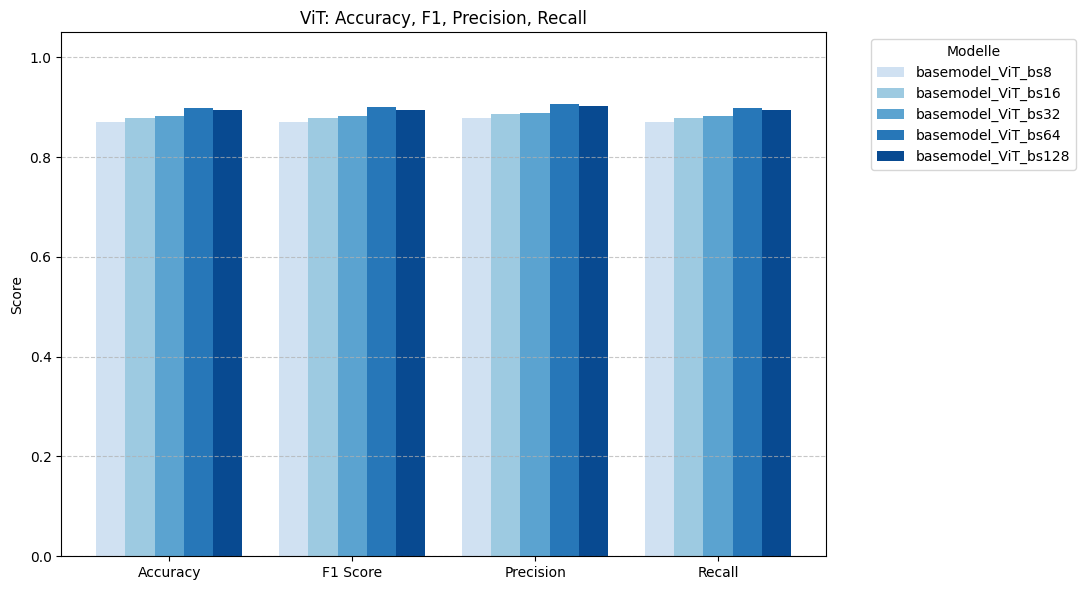

In [ ]:
# Metriken & Modelle
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
n_metrics = len(metrics)
n_models = len(df_vit_results)
group_width = 1.2  
bar_width = group_width / n_models
gap = 0.5  
# X-Positionen der Metrikgruppen
x = np.arange(n_metrics) * (1 + gap)

#  Farben aus der "Blues"-Colormap
cmap = cm.get_cmap('Blues')
colors = [cmap(0.2 + 0.7 * i / max(1, n_models - 1)) for i in range(n_models)]

# Plot
fig, ax = plt.subplots(figsize=(11, 6))

for i, (idx, row) in enumerate(df_results.iterrows()):
    scores = [row[m] for m in metrics]
    offset = x + i * bar_width - group_width / 2 + bar_width / 2
    ax.bar(offset, scores, width=bar_width, label=row['Model'], color=colors[i])

# Achsen & Styling
ax.set_ylabel('Score')
ax.set_title('ViT: Accuracy, F1, Precision, Recall')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.05)
ax.legend(title="Modelle", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [3]:
# Evaluation Tuning mit ViT

# Liste der Modelle
models = [
    "basemodel_ViT_bs64",
    "basemodel_ViT_bs64+augm",
    "basemodel_ViT_bs64+augm+iNat"
]

# Basispfad zu den .pkl-Dateien
base_path = "basemodel_outputs"

# Ergebnisse speichern
vit_tuning_results = []

for model_name in models:
    path = f"{base_path}/{model_name}.pkl"
    
    # Modell laden
    learn = load_learner(path)

    # Vorhersagen
    preds, targs = learn.get_preds(dl=test_dl)
    y_pred = torch.argmax(preds, dim=1).numpy()
    y_true = targs.numpy()
    
    # Metriken berechnen
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    
    vit_tuning_results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall
    })

# DataFrame mit Ergebnissen
df_vit_tuning = pd.DataFrame(vit_tuning_results)
print(df_vit_tuning)


KeyboardInterrupt: 

In [ ]:
# Metriken & Modelle
metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
n_metrics = len(metrics)
n_models = len(df_vit_tuning)
group_width = 1.2  
bar_width = group_width / n_models
gap = 0.5 

# X-Positionen der Metrikgruppen
x = np.arange(n_metrics) * (1 + gap)

# Farben aus der "Blues"-Colormap
cmap = cm.get_cmap('Blues')
colors = [cmap(0.2 + 0.7 * i / max(1, n_models - 1)) for i in range(n_models)]

# Mapping der Modellnamen für schönere Beschriftung
label_map = {
    "basemodel_ViT_bs64": "ViT Basemodel",
    "basemodel_ViT_bs64+augm": "ViT with augmented images",
    "basemodel_ViT_bs64+augm+iNat": "ViT with augmented and scraped images"
}

# Plot
fig, ax = plt.subplots(figsize=(11, 6))

for i, (idx, row) in enumerate(df_results.iterrows()):
    scores = [row[m] for m in metrics]
    offset = x + i * bar_width - group_width / 2 + bar_width / 2
    label = label_map.get(row['Model'], row['Model'])  # Fallback auf Originalname
    ax.bar(offset, scores, width=bar_width, label=label, color=colors[i])

# Achsen & Styling
ax.set_ylabel('Score')
ax.set_title('ViT: Accuracy, F1, Precision, Recall')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.05)
ax.legend(title="Modelle", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()